## stackSentinel.py Overview

`stackSentinel.py` is a key script in the ISCE processing chain, designed to automate the preprocessing of Sentinel-1 SAR data. It orchestrates various steps from initial data unpacking to generating interferograms, coherence maps, and applying necessary filters. Below is an overview of its workflow:

### 1. Data Input and Unpacking
The script begins by organizing and unpacking Sentinel-1 SAR data. It sets up directories and prepares the raw SAR data for further processing. This typically involves downloading and unpacking the raw Sentinel-1 products.

### 2. Interferogram Calculation
After unpacking, `stackSentinel.py` facilitates the calculation of interferograms between pairs of SAR images. These interferograms are the basis for detecting ground displacement.

### 3. Coherence Map Generation
The script generates coherence maps that quantify the correlation between SAR image pairs. High coherence values indicate stable surfaces, while low coherence values suggest changes or noisy areas.

### 4. Phase Unwrapping and Topographic Phase Removal
To process the interferograms, the script performs phase unwrapping, eliminating ambiguities in phase values. It also removes the topographic phase component, isolating the deformation signal from the topographic effects.

### 5. Filtering and Refining
Several filtering steps are included in the script to remove noise from the interferograms and coherence maps. This step enhances the quality of the data by smoothing and reducing phase errors.

### 6. Coherence Thresholding and Final Filtering
The script applies a coherence threshold, removing low-coherence regions, and further refines the coherence map by filtering out any remaining noise.

### 7. Output: `filt_fine.cor`
The final output of the script is a filtered and processed coherence map, stored in the `/merged/interferograms/` directory. This file, `filt_fine.cor`, serves as the foundation for any subsequent analysis of surface displacements or deformations.

### Purpose
The main purpose of `stackSentinel.py` is to automate the preprocessing steps for Sentinel-1 data, ensuring that the generated interferograms and coherence maps are of high quality and suitable for further analysis.


In [ ]:
   
from mintpy.utils.writefile import * 
from osgeo import gdal  
import os, sys
import numpy as np
import math
import geopandas as gpd
from shapely.geometry import Polygon


## geobbox to SAR row/col in the azimuth&range direction 
def bbox2SAR(lat_min, lat_max, lon_min, lon_max, lat_data, lon_data):
    #  convert geographic bounding box to SAR ROI indicies. (azimuth and range)
    # <1> lat_min (float)     : minimum latitude
    # <2> lat_max (float)     : maximum latitude
    # <3> lon_min (float)     : minimum longitude
    # <4> lon_max (float)     : maximum longitude
    # <5> lat_data (np.array) : the latitude lookuptable lat.rdr  
    # <6> lon_data (np.array) : the lontitude lookuptable lon.rdr
    # <return> region_rec: return the SAR row col list 
    S, N, W, E = lat_min, lat_max, lon_min, lon_max
    geo_coord = [W, N, E, S]
    data_map =  (lon_data >= geo_coord[0])*(lon_data <= geo_coord[2])*(lat_data>=geo_coord[3])*(lat_data<=geo_coord[1])
    region_list = np.argwhere(data_map==1)
    region_rec = [10*math.floor(region_list[:,0].min()/10),10*math.ceil(region_list[:,0].max()/10),\
              10*math.floor(region_list[:,1].min()/10),10*math.ceil(region_list[:,1].max()/10)]
    return region_rec
    
## convert ISCE2 formatted file to npArray
def read_isce_file(file):
    # convert a GDAL_realiable file (usually ISCE2 file) to a numpy array 
    # <1> file(str): a string-path of input file 
    _, ext = os.path.splitext(file)
    ds = gdal.Open(file,gdal.GA_ReadOnly)
    print("input dataset BandsCount : ", ds.RasterCount)
    ## get the phase band for the unw data
    if ext != ".unw":band = ds.GetRasterBand(1)
    else:band = band = ds.GetRasterBand(2)
    data = np.expand_dims(band.ReadAsArray(), 2)
    W, L, N = data.shape
    loader = np.zeros([W, L, N], dtype=np.float32)
    loader[:,:,0] = data[:,:,0]
    return loader


## there may be some problems in the funtion @
## don`t use it 
def write_gdal_file(arr, output_filepath, data_type=gdal.GDT_Float32):
    if len(arr.shape) == 2:
        rows, cols = arr.shape
        bands = 1
        data_to_write = arr
    elif len(arr.shape) == 3:
        rows, cols, bands = arr.shape
        data_to_write = arr[:, :, 0] if bands == 1 else arr
    else:
        raise ValueError("Array must be 2D or 3D")
    driver = gdal.GetDriverByName('ENVI')    
    dataset = driver.Create(output_filepath, cols, rows, 1, data_type)
    if dataset is None:
        raise RuntimeError(f"Could not create file: {output_filepath}")
    if len(arr.shape) == 2:
        dataset.GetRasterBand(1).WriteArray(data_to_write)
    else:
        dataset.GetRasterBand(1).WriteArray(data_to_write[:, :])
    dataset.FlushCache()
    dataset = None
    print(f"GDAL write {output_filepath} finished")


## write np.array to the ISCE2 file according to the input array
def write_arr2file(arr, output_filepath):
    ## write np.array to the ISCE2 file according to the input array
    ## <1> arr(numpy.array) : the numpy array to convert
    ## <2> out_path (str)   : the output path of the arr2ISCEfile
    mirror_dic = {
        ".unw": "MOD_isce_unw", 
        ".cor": "isce_cor", 
        ".rdr": "isce_cor", 
        ".int": "isce_int",
        ".full": "envi"
    }
    _, ext = os.path.splitext(output_filepath)
    if ext == ".full":
        write_gdal_file(arr, output_filepath)
        return
    if ext not in mirror_dic:
        raise ValueError(f"Unsupported file extension: {ext}")
    file_type = mirror_dic[ext]
    write_isce_file(
        data = arr[:,:,0],
        out_file = output_filepath ,
        file_type = file_type
    )
    print(f"write {output_filepath} finished ")

In [2]:
import os
import numpy as np
from osgeo import gdal
import traceback
import re


def batch_crop_filt_fine_cor(base_path, geom_reference_path, output_base_path):
    """
    Batch crop all filt_fine.cor files and simultaneously crop corresponding lat and lon files.
    
    Parameters:
    base_path: The base path containing filt_fine.cor files
    geom_reference_path: The geometry reference path containing lat and lon files
    output_base_path: The base path where cropped files will be saved
    """
    
    # Use the provided latitude and longitude range
    lat_min, lat_max = 42.625, 42.635
    lon_min, lon_max = 13.28, 13.30
    
    print(f"Using cropping region: Latitude[{lat_min}, {lat_max}], Longitude[{lon_min}, {lon_max}]")
    
    # Look for lat and lon files
    lat_file = os.path.join(geom_reference_path, "lat.rdr")
    lon_file = os.path.join(geom_reference_path, "lon.rdr")
    
    if not os.path.exists(lat_file):
        # Try other possible file names
        lat_files = [f for f in os.listdir(geom_reference_path) if "lat" in f.lower() and not f.startswith('.')]
        if lat_files:
            lat_file = os.path.join(geom_reference_path, lat_files[0])
            print(f"Using found latitude file: {lat_file}")
        else:
            print(f"Error: Could not find lat file in {geom_reference_path}")
            return
    
    if not os.path.exists(lon_file):
        # Try other possible file names
        lon_files = [f for f in os.listdir(geom_reference_path) if "lon" in f.lower() and not f.startswith('.')]
        if lon_files:
            lon_file = os.path.join(geom_reference_path, lon_files[0])
            print(f"Using found longitude file: {lon_file}")
        else:
            print(f"Error: Could not find lon file in {geom_reference_path}")
            return
    
    print(f"Using lat file: {lat_file}")
    print(f"Using lon file: {lon_file}")
    
    # Read lat and lon data
    lat_data = read_isce_file(lat_file)
    lon_data = read_isce_file(lon_file)
    print(f"Lat file shape: {lat_data.shape}")
    print(f"Lon file shape: {lon_data.shape}")
    
    # Calculate the cropping region (SAR coordinates)
    region_rec = bbox2SAR(lat_min, lat_max, lon_min, lon_max, lat_data, lon_data)
    if len(region_rec) != 4:
        print("Invalid region coordinates")
        return
    
    y_min, y_max, x_min, x_max = region_rec
    height = y_max - y_min
    width = x_max - x_min
    print(f"Geographical coordinates converted to SAR coordinates: [{y_min}, {y_max}, {x_min}, {x_max}]")
    print(f"SAR image range: Rows {y_min} to {y_max}, Columns {x_min} to {x_max}")
    print(f"SAR image size: {height} × {width} (Height × Width)")
    
    # Check if the cropping region is valid
    if height <= 0 or width <= 0:
        print("Error: Invalid cropping region, height or width is 0")
        return
    
    # Crop the lat and lon files
    lat_cropped = lat_data[y_min:y_max, x_min:x_max]
    lon_cropped = lon_data[y_min:y_max, x_min:x_max]
    
    # Save the cropped lat and lon files
    lat_output = os.path.join(output_base_path, "lat_cropped.rdr")
    lon_output = os.path.join(output_base_path, "lon_cropped.rdr")
    
    write_arr2file(lat_cropped, lat_output)
    write_arr2file(lon_cropped, lon_output)
    
    print(f"Cropped lat file saved: {lat_output}, shape: {lat_cropped.shape}")
    print(f"Cropped lon file saved: {lon_output}, shape: {lon_cropped.shape}")
    
    # Walk through the directory structure and find filt_fine.cor files
    cor_files = []
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file == "filt_fine.cor":
                cor_files.append(os.path.join(root, file))
    
    print(f"Found {len(cor_files)} filt_fine.cor files")
    
    # Process each file
    for i, cor_file in enumerate(cor_files):
        print(f"\nProcessing file {i+1}/{len(cor_files)}: {cor_file}")
        
        try:
            # Extract date information from file path
            # Assuming the path format is: .../YYYYMMDD_YYYYMMDD/filt_fine.cor
            date_match = re.search(r'(\d{8}_\d{8})', cor_file)
            if date_match:
                date_str = date_match.group(1)
                print(f"Extracted date information: {date_str}")
            else:
                # If no date is found, use the parent directory name
                parent_dir = os.path.basename(os.path.dirname(cor_file))
                date_str = parent_dir
                print(f"Using parent directory name as date: {date_str}")
            
            # Create the output file name
            output_file = os.path.join(output_base_path, f"{date_str}_filt_fine.cor")
            
            # Check if the output file already exists
            if os.path.exists(output_file):
                print(f"Skipping existing file: {output_file}")
                continue
            
            # Call the cropping function
            crop_single_band_file(
                cor_file, y_min, y_max, x_min, x_max, output_file
            )
            
            print(f"Successfully cropped: {output_file}")
            
        except Exception as e:
            print(f"Error processing file {cor_file}: {str(e)}")
            traceback.print_exc()

def crop_single_band_file(file, y_min, y_max, x_min, x_max, out_file):
    """Crop a single band file (such as filt_fine.cor)"""
    
    # Read data
    data = read_isce_file(file)
    print(f"Original data shape: {data.shape}")
    
    # Check if the cropping region exceeds data boundaries
    data_height, data_width = data.shape[0], data.shape[1]
    if y_max > data_height or x_max > data_width:
        print(f"Warning: Cropping region exceeds data boundaries, adjusting cropping region")
        y_max = min(y_max, data_height)
        x_max = min(x_max, data_width)
        print(f"Adjusted SAR coordinates: [{y_min}, {y_max}, {x_min}, {x_max}]")
    
    # Crop data
    if len(data.shape) == 2:  # Single band data
        data_crop = data[y_min:y_max, x_min:x_max]
    elif len(data.shape) == 3:  # Multi-band data
        data_crop = data[y_min:y_max, x_min:x_max, :]
    else:
        print(f"Unsupported data dimensions: {len(data.shape)}")
        return
    
    print(f"Cropped data shape: {data_crop.shape}")
    
    # Calculate data statistics
    if np.iscomplexobj(data_crop):
        print(f"Complex data range: Min magnitude={np.min(np.abs(data_crop)):.4f}, Max magnitude={np.max(np.abs(data_crop)):.4f}")
    else:
        print(f"Data range: Min={np.min(data_crop):.4f}, Max={np.max(data_crop):.4f}")
    
    # Save cropped data
    if not file.endswith("full"):
        write_arr2file(data_crop, out_file)
    else:
        write_gdal_file(data_crop, out_file)

def main():
    """Main function"""
    
    # Set path parameters
    base_path = "/data6/WORKDIR/AmatriceSenDT22/merged/interferograms"
    geom_reference_path = "/data6/WORKDIR/AmatriceSenDT22/merged/geom_reference"
    output_base_path = "/data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped"  # Output directory
    
    # Ensure the output directory exists
    os.makedirs(output_base_path, exist_ok=True)
    
    print("Starting batch crop of filt_fine.cor files")
    print(f"Input path: {base_path}")
    print(f"Geometry reference path: {geom_reference_path}")
    print(f"Output path: {output_base_path}")
    
    # Execute batch cropping
    batch_crop_filt_fine_cor(
        base_path, geom_reference_path, output_base_path
    )
    
    print("\nBatch cropping complete!")

if __name__ == '__main__':
    main()


Starting batch crop of filt_fine.cor files
Input path: /data6/WORKDIR/AmatriceSenDT22/merged/interferograms
Geometry reference path: /data6/WORKDIR/AmatriceSenDT22/merged/geom_reference
Output path: /data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped
Using cropping region: Latitude[42.625, 42.635], Longitude[13.28, 13.3]
Using lat file: /data6/WORKDIR/AmatriceSenDT22/merged/geom_reference/lat.rdr
Using lon file: /data6/WORKDIR/AmatriceSenDT22/merged/geom_reference/lon.rdr
input dataset BandsCount :  1
input dataset BandsCount :  1
Lat file shape: (2858, 26031, 1)
Lon file shape: (2858, 26031, 1)
Geographical coordinates converted to SAR coordinates: [950, 1060, 21330, 21870]
SAR image range: Rows 950 to 1060, Columns 21330 to 21870
SAR image size: 110 × 540 (Height × Width)
write file: /data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/lat_cropped.rdr
write file: /data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/lat_cropped.rdr.xml
write file: /data6/WORKD

In [3]:
import os
import datetime
import numpy as np
import pickle
import shutil
import re
from osgeo import gdal

# Set directory paths
cropped_dir = "/data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped"
output_dir = "/data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped"
next_date = "20160821_20160902"  # Predicted time period

# Earthquake event date
event_date = datetime.datetime(2016, 8, 24)

def find_cor_files_sorted(cropped_dir):
    """
    Find all *_filt_fine.cor files under cropped_dir,
    sort by the start date, and return [(start_datetime, date_str, full_path), ...]
    where date_str is in the format '20160716_20160728'.
    """
    file_infos = []
    for root, dirs, files in os.walk(cropped_dir):
        for fname in files:
            if not fname.endswith("filt_fine.cor"):
                continue
            m = re.search(r"(\d{8}_\d{8})", fname)
            if not m:
                print(f"Skipping file without date pattern: {os.path.join(root, fname)}")
                continue
            date_str = m.group(1)
            start_str, end_str = date_str.split("_")
            start_dt = datetime.datetime.strptime(start_str, "%Y%m%d")
            full_path = os.path.join(root, fname)
            file_infos.append((start_dt, date_str, full_path))

    # Sort by start date
    file_infos.sort(key=lambda x: x[0])
    print(f"Found {len(file_infos)} cropped .cor files")
    for dt, dstr, path in file_infos:
        print(dt.date(), dstr, "->", path)
    return file_infos

def read_isce_file(file):
    """
    Read ISCE2 formatted files (such as .unw files) and return as a NumPy array.
    """
    _, ext = os.path.splitext(file)
    ds = gdal.Open(file, gdal.GA_ReadOnly)
    print("Input dataset BandsCount:", ds.RasterCount)

    # If it's a .unw file, get the phase band data
    if ext != ".unw":
        band = ds.GetRasterBand(1)
    else:
        band = ds.GetRasterBand(2)
        
    data = np.expand_dims(band.ReadAsArray(), 2)
    print(f"Data shape: {data.shape}")
    W, L, N = data.shape
    loader = np.zeros([W, L, N], dtype=np.float32)
    loader[:, :, 0] = data[:, :, 0]
    return loader

def build_insar_cube_from_cor(file_infos, use="amplitude"):
    """
    Build InSAR cube (H, W, T-1) from sorted .cor files
    
    use:
      - "amplitude": Use |cor|
      - "phase": Use np.angle(cor)
      - "real": Use np.real(cor)
    """
    if len(file_infos) == 0:
        raise RuntimeError("No .cor files found")

    # Read the first file to determine size
    _, first_datestr, first_path = file_infos[0]
    first_data = read_isce_file(first_path)  # Should return 2D array (H, W), possibly complex
    print(f"First image {first_datestr} shape: {first_data.shape}, dtype: {first_data.dtype}")

    # If first_data is a 3D array (H, W, 1), use [:2] to get H and W
    H, W = first_data.shape[:2]
    T = len(file_infos)

    # The last dimension will be T-1, as the data before the earthquake
    cube = np.zeros((H, W, T-1), dtype=np.float32)
    dates = []

    # Use only the first T-1 files, the last one is for geninue.npy
    for t, (start_dt, date_str, path) in enumerate(file_infos[:-1]):  # Use only the first T-1 files
        print(f"[{t+1}/{T-1}] Reading {date_str} -> {path}")
        arr = read_isce_file(path)

        if arr.shape[:2] != (H, W):
            raise ValueError(f"File {path} shape {arr.shape} does not match the first image {first_data.shape}")

        if np.iscomplexobj(arr):
            if use == "amplitude":
                arr_use = np.abs(arr)
            elif use == "phase":
                arr_use = np.angle(arr)
            elif use == "real":
                arr_use = np.real(arr)
            else:
                raise ValueError(f"Unknown 'use' option: {use}")
        else:
            arr_use = arr

        # Convert to a 2D array (H, W), and store it in the cube
        cube[:, :, t] = arr_use[:, :, 0].astype(np.float32)
        dates.append(date_str)

    print(f"Final cube shape: {cube.shape} (H, W, T-1)")
    return cube, dates

def calculate_std_from_cor(cor, chunk_size=50):
    """
    Calculate standard deviation from coherence image
    Calculate standard deviation for each band
    """
    rows, cols, bands = cor.shape
    result = np.full_like(cor, np.nan, dtype=np.float32)
    
    # Add numerical stability factor
    epsilon = 1e-8
    
    # Iterate over the whole image in chunks (no overlap)
    for i in range(0, rows, chunk_size):
        for j in range(0, cols, chunk_size):
            # Calculate the boundaries for the current chunk
            end_i = min(i + chunk_size, rows)
            end_j = min(j + chunk_size, cols)
            
            # Extract current chunk data
            chunk = cor[i:end_i, j:end_j, :]  # Process all bands
            
            # Calculate the standard deviation for each band separately
            for band in range(bands):
                band_chunk = chunk[:, :, band]
                with np.errstate(divide='ignore', invalid='ignore'):
                    # Calculate standard deviation: std = sqrt((1 - cor^2) / 2*cor^2)
                    denominator = band_chunk**2
                    valid_mask = (denominator > epsilon)
                    std_chunk = np.where(valid_mask,
                                         np.sqrt((1 - denominator) / (2*denominator)),
                                         0.0)
                
                # Store the standard deviation in the corresponding position
                result[i:end_i, j:end_j, band] = std_chunk
    
    # Retain original invalid regions
    nan_mask = np.isnan(cor)
    zero_mask = (cor == 0)
    result[nan_mask] = np.nan
    result[zero_mask] = 0.0
    
    return result

def save_dataset(cube, dates, output_subfolder, geninue_data=None):
    """
    Save dataset (.npy and .pkl) to specified subfolder
    """
    os.makedirs(output_subfolder, exist_ok=True)
    
    # Save data
    data_path = os.path.join(output_subfolder, "data.npy")
    np.save(data_path, cube)
    print(f"Dataset saved to {data_path}")

    # Save dates
    dates_path = os.path.join(output_subfolder, "dates.pkl")
    with open(dates_path, "wb") as f:
        pickle.dump(dates, f)
    print(f"Dates list saved to {dates_path}")

    # Save geninue.npy (post-earthquake cor)
    if geninue_data is not None:
        geninue_path = os.path.join(output_subfolder, "geninue.npy")
        np.save(geninue_path, geninue_data)
        print(f"Saved geninue.npy to {geninue_path}")

    # Save standard deviation data
    data_std = calculate_std_from_cor(cube)
    data_std_path = os.path.join(output_subfolder, "data_std.npy")
    np.save(data_std_path, data_std)
    print(f"Saved standard deviation data to {data_std_path}")

    if geninue_data is not None:
        # Ensure geninue_data is a 3D array
        if geninue_data.ndim == 2:
            geninue_data = np.expand_dims(geninue_data, axis=-1)  # Convert to a 3D array, shape (rows, cols, 1)
        
        geninue_std = calculate_std_from_cor(geninue_data)
        geninue_std_path = os.path.join(output_subfolder, "geninue_std.npy")
        np.save(geninue_std_path, geninue_std)
        print(f"Saved geninue_std.npy to {geninue_std_path}")

def main():
    # Get cropped files
    file_infos = find_cor_files_sorted(cropped_dir)

    # Select training set (before 20160824)
    train_file_infos = [info for info in file_infos if info[0] < event_date]

    # Build training set data
    cube, dates = build_insar_cube_from_cor(train_file_infos, use="amplitude")

    # Generate geninue.npy (post-earthquake cor data, i.e., the last time interference pair's cor)
    _, geninue_date_str, geninue_path = file_infos[-1]  # Last time period data
    geninue_data = read_isce_file(geninue_path)
    geninue_data = np.abs(geninue_data[:, :, 0])  # Get amplitude and remove the last dimension

    # Save dataset
    output_subfolder = os.path.join(output_dir, "dataset")
    save_dataset(cube, dates, output_subfolder, geninue_data)

if __name__ == "__main__":
    main()


Found 10 cropped .cor files
2016-03-06 20160306_20160330 -> /data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/20160306_20160330_filt_fine.cor
2016-03-30 20160330_20160517 -> /data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/20160330_20160517_filt_fine.cor
2016-05-17 20160517_20160529 -> /data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/20160517_20160529_filt_fine.cor
2016-05-29 20160529_20160610 -> /data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/20160529_20160610_filt_fine.cor
2016-06-10 20160610_20160704 -> /data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/20160610_20160704_filt_fine.cor
2016-07-04 20160704_20160716 -> /data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/20160704_20160716_filt_fine.cor
2016-07-16 20160716_20160728 -> /data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/20160716_20160728_filt_fine.cor
2016-07-28 20160728_20160809 -> /data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/2016

2025-12-02 18:06:03,395 - matplotlib - DEBUG - matplotlib data path: /home/yangyc/.conda/envs/isce_env/lib/python3.8/site-packages/matplotlib/mpl-data
2025-12-02 18:06:03,405 - matplotlib - DEBUG - CONFIGDIR=/home/yangyc/.config/matplotlib
2025-12-02 18:06:03,408 - matplotlib - DEBUG - interactive is False
2025-12-02 18:06:03,410 - matplotlib - DEBUG - platform is linux
2025-12-02 18:06:03,490 - matplotlib - DEBUG - CACHEDIR=/home/yangyc/.cache/matplotlib
2025-12-02 18:06:03,495 - matplotlib.font_manager - DEBUG - Using fontManager instance from /home/yangyc/.cache/matplotlib/fontlist-v330.json
Using device: cpu
Data shape: (110, 540, 9)
Loaded dates: ['20160306_20160330', '20160330_20160517', '20160517_20160529', '20160529_20160610', '20160610_20160704', '20160704_20160716', '20160716_20160728', '20160728_20160809', '20160809_20160821']
Epoch 1/15, Train Loss: 0.4239, Val Loss: 0.3906
Epoch 2/15, Train Loss: 0.3493, Val Loss: 0.3248
Epoch 3/15, Train Loss: 0.3311, Val Loss: 0.3582
Epo

/tmp/ipykernel_124279/2484477997.py:264: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Prediction results saved to: /data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/predict/future_predictions.npy
Trained model saved to: /data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/predict/best_model.pth
2025-12-02 18:09:02,094 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-12-02 18:09:02,101 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-12-02 18:09:02,107 - matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-12-02 18:09:02,109 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/home/yangyc/.conda/envs/isce_env/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/cmss10.ttf', name='cmss10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-12-02 18:09:02,111 - matplotlib.font_manager - D

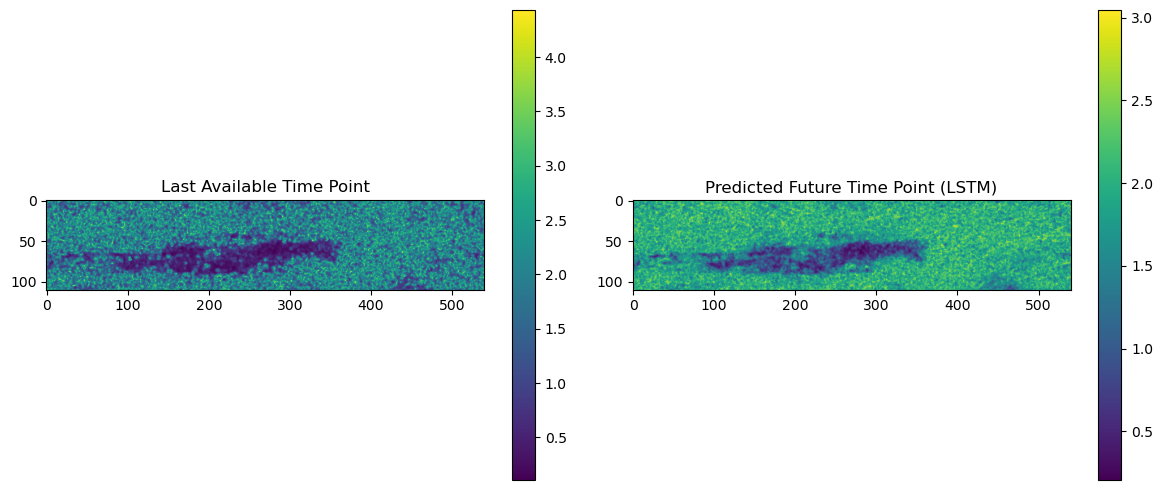

Prediction results saved successfully!


In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pickle
import os

# ============================================================
# 1. Import Libraries
# ============================================================

# ============================================================
# 2. Dataset Definition
# ============================================================
class InSARDataset(Dataset):
    """
    Custom dataset for InSAR time series.

    Args:
        data (numpy.ndarray): InSAR cube, shape (H, W, T).
        dates (list[str]): List of interferogram intervals, e.g. ["20150815_20150827", ...].
        window_size (int): Temporal window size. Default: 20.
        is_prediction (bool): If True, builds dataset for forecasting the next step.
    """
    def __init__(self, data, dates, window_size=20, is_prediction=False):
        self.data = data
        self.height, self.width, self.time_steps = data.shape
        self.window_size = window_size
        self.is_prediction = is_prediction

        # ---- Extract temporal features ----
        self.time_features = []
        for date_str in dates:
            start_date, end_date = date_str.split('_')
            start = datetime.datetime.strptime(start_date, '%Y%m%d')
            end = datetime.datetime.strptime(end_date, '%Y%m%d')

            year_sin = np.sin(2 * np.pi * start.year / 2100)
            year_cos = np.cos(2 * np.pi * start.year / 2100)
            month_sin = np.sin(2 * np.pi * start.month / 12)
            month_cos = np.cos(2 * np.pi * start.month / 12)
            day_sin = np.sin(2 * np.pi * start.day / 31)
            day_cos = np.cos(2 * np.pi * start.day / 31)
            interval = (end - start).days

            self.time_features.append([year_sin, year_cos, month_sin, month_cos,
                                       day_sin, day_cos, interval])
        self.time_features = np.array(self.time_features)

        # ---- Normalize each pixel individually ----
        self.scalers = {}
        self.scaled_data = np.zeros_like(self.data, dtype=np.float32)

        for i in range(self.height):
            for j in range(self.width):
                pixel_ts = self.data[i, j, :]
                scaler = MinMaxScaler(feature_range=(-1, 1))
                self.scaled_data[i, j, :] = scaler.fit_transform(pixel_ts.reshape(-1, 1)).flatten()
                self.scalers[(i, j)] = scaler

        # ---- Build sample indices ----
        self.samples = [(i, j) for i in range(self.height) for j in range(self.width)]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        i, j = self.samples[idx]
        pixel_ts = self.scaled_data[i, j, :]

        if not self.is_prediction:  # Training
            x = pixel_ts[:-1]  # first T-1 steps
            y = pixel_ts[-1]   # last step
            time_feat = self.time_features[:-1]
            target_time_feat = self.time_features[-1]
        else:  # Prediction
            x = pixel_ts
            y = 0.0  # placeholder
            time_feat = self.time_features[:self.time_steps]
            target_time_feat = self.time_features[-1]

        return {
            'pixel_coords': torch.tensor([i, j]),
            'x': torch.tensor(x, dtype=torch.float32),
            'time_features': torch.tensor(time_feat, dtype=torch.float32),
            'target_time_features': torch.tensor(target_time_feat, dtype=torch.float32),
            'y': torch.tensor(y, dtype=torch.float32)
        }

# ============================================================
# 3. LSTM Model
# ============================================================
class InSARLSTM(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=2, dropout=0.1, time_feat_dim=7):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.input_embedding = nn.Linear(input_dim, hidden_dim)
        self.time_embedding = nn.Linear(time_feat_dim, hidden_dim)

        self.lstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        self.target_time_proj = nn.Linear(time_feat_dim, hidden_dim)

        self.output_layer = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, src, time_features, target_time_features):
        batch_size = src.size(0)
        src = src.unsqueeze(-1)  # [B, T, 1]
        src = self.input_embedding(src)  # [B, T, H]
        time_embed = self.time_embedding(time_features)  # [B, T, H]

        combined_input = src + time_embed
        lstm_out, (h_n, c_n) = self.lstm(combined_input)
        seq_repr = h_n[-1]  # last hidden state

        target_time_embed = self.target_time_proj(target_time_features)
        combined = torch.cat([seq_repr, target_time_embed], dim=-1)

        output = self.output_layer(combined)
        return output.squeeze(-1)

# ============================================================
# 4. Training and Prediction Utilities
# ============================================================
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, device='cuda'):
    model.to(device)
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            x = batch['x'].to(device)
            time_features = batch['time_features'].to(device)
            target_time_features = batch['target_time_features'].to(device)
            y = batch['y'].to(device)

            optimizer.zero_grad()
            outputs = model(x, time_features, target_time_features)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * x.size(0)
        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                x = batch['x'].to(device)
                time_features = batch['time_features'].to(device)
                target_time_features = batch['target_time_features'].to(device)
                y = batch['y'].to(device)

                outputs = model(x, time_features, target_time_features)
                loss = criterion(outputs, y)
                val_loss += loss.item() * x.size(0)
        val_loss /= len(val_loader.dataset)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')

    return model


def predict_future(model, dataset, device='cuda'):
    model.eval()
    predictions = np.zeros((dataset.height, dataset.width))
    dataloader = DataLoader(dataset, batch_size=256, shuffle=False)

    with torch.no_grad():
        for batch in dataloader:
            coords = batch['pixel_coords'].numpy()
            x = batch['x'].to(device)
            time_features = batch['time_features'].to(device)
            target_time_features = batch['target_time_features'].to(device)

            outputs = model(x, time_features, target_time_features)
            for i in range(len(coords)):
                pixel_i, pixel_j = coords[i]
                scaler = dataset.scalers[(pixel_i, pixel_j)]
                predictions[pixel_i, pixel_j] = scaler.inverse_transform(
                    outputs[i].cpu().numpy().reshape(-1, 1))[0, 0]

    return predictions

# ============================================================
# 5. Save Prediction Results
# ============================================================
def save_predict_results(predictions, model, output_path):
    os.makedirs(output_path, exist_ok=True)

    # Save predictions
    predict_data_path = os.path.join(output_path, "future_predictions.npy")
    np.save(predict_data_path, predictions)
    print(f"Prediction results saved to: {predict_data_path}")

    # Save the trained model
    model_path = os.path.join(output_path, "best_model.pth")
    torch.save(model.state_dict(), model_path)
    print(f"Trained model saved to: {model_path}")

# ============================================================
# 6. Example Usage
# ============================================================

# ---- Device ----
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ============================================================
# Load Data and Dates
# ============================================================

# ---- Data ----
data_path = "/data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/dataset/data_std.npy"   # <-- replace with your file path
data = np.load(data_path)
print(f"Data shape: {data.shape}")   # should be (H, W, T)

# ---- Load Dates from Pickle ----
with open('/data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/dataset/dates.pkl', 'rb') as f:
    dates = pickle.load(f)

print(f"Loaded dates: {dates}")

# ---- Dataset ----
full_dataset = InSARDataset(data, dates)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# ---- Model ----
model = InSARLSTM(input_dim=1, hidden_dim=64, num_layers=2, dropout=0.1, time_feat_dim=7)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ---- Train ----
model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=15, device=device)

# ---- Load Best Model ----
model.load_state_dict(torch.load('best_model.pth'))

# ---- Predict ----
next_date = "20160821_20160902"
all_dates = dates + [next_date]
predict_dataset = InSARDataset(data, all_dates, is_prediction=True)

future_predictions = predict_future(model, predict_dataset, device)

# ---- Save the Prediction Results ----
predict_output_subfolder = os.path.join(output_dir, "predict")
save_predict_results(future_predictions, model, predict_output_subfolder)

# ---- Visualization ----
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(data[:, :, -1], cmap='viridis')
plt.colorbar()
plt.title('Last Available Time Point')

plt.subplot(1, 2, 2)
plt.imshow(future_predictions, cmap='viridis')
plt.colorbar()
plt.title('Predicted Future Time Point (LSTM)')

plt.tight_layout()
plt.savefig('prediction.png')
plt.show()

print("Prediction results saved successfully!")


Loaded geninue_std with shape (110, 540)
Loaded future_predictions with shape (110, 540)
Score map computed successfully.
Result saved as score.npy
2025-12-02 18:12:28,108 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f81a6f42f40>
2025-12-02 18:12:28,160 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f81a6ec0910>
2025-12-02 18:12:28,217 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f81a6eb7fd0>


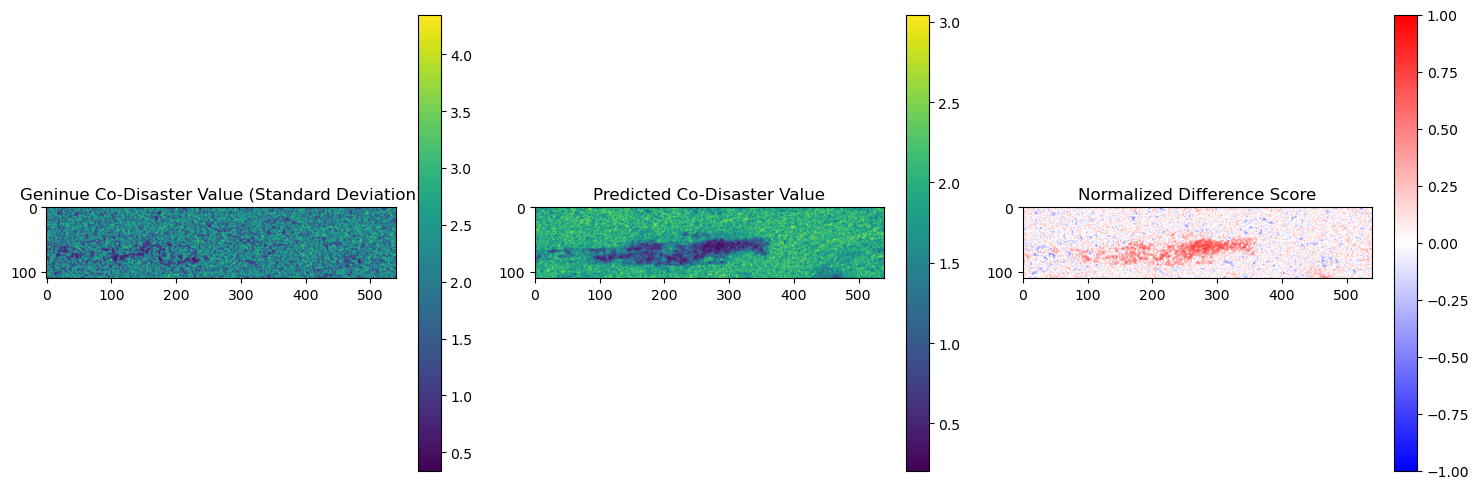

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os

# ============================================================
# 1. Function: Normalized Difference Calculation
# ============================================================
def calculate_difference(interferogram1, interferogram2, chunk_size=1024):
    """
    Compute the normalized difference between two interferograms
    with block-wise processing to reduce memory usage.
    
    Args:
        interferogram1 (np.ndarray): First interferogram (2D array).
        interferogram2 (np.ndarray): Second interferogram (2D array).
        chunk_size (int): Block size for processing to avoid memory overflow.
        
    Returns:
        np.ndarray: Difference map (float32), with NaN for invalid pixels.
    """
    if interferogram1.shape != interferogram2.shape:
        raise ValueError("Both interferograms must have the same shape.")
    
    rows, cols = interferogram1.shape
    difference = np.zeros((rows, cols), dtype=np.float32)

    chunk_rows = max(1, min(chunk_size, rows))
    chunk_cols = max(1, min(chunk_size, cols))

    for i in range(0, rows, chunk_rows):
        for j in range(0, cols, chunk_cols):
            end_i = min(i + chunk_rows, rows)
            end_j = min(j + chunk_cols, cols)

            if end_i <= i or end_j <= j:
                continue

            chunk1 = interferogram1[i:end_i, j:end_j]
            chunk2 = interferogram2[i:end_i, j:end_j]

            epsilon = 1e-8
            denominator = chunk1 + chunk2 + epsilon
            valid_mask = denominator != 0

            diff_chunk = np.full_like(chunk1, np.nan, dtype=np.float32)
            diff_chunk[valid_mask] = (chunk1[valid_mask] - chunk2[valid_mask]) / denominator[valid_mask]

            difference[i:end_i, j:end_j] = diff_chunk

    mask = np.isnan(interferogram1) | np.isnan(interferogram2) | (interferogram1 == 0) | (interferogram2 == 0)
    difference[mask] = np.nan

    return difference


# ============================================================
# 2. Load Data
# ============================================================
# Load the geninue_std.npy (geninue's standard deviation) and future_predictions.npy (predicted results)
geninue_std_path = "/data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/dataset/geninue_std.npy"
future_predictions_path = "/data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/predict/future_predictions.npy"

geninue_std = np.load(geninue_std_path)
future_predictions = np.load(future_predictions_path)

# Option 1: Convert geninue_std to 2D (if necessary)
geninue_std = np.squeeze(geninue_std, axis=-1)

# Option 2: Alternatively, you can expand future_predictions to 3D (if necessary)
# future_predictions = np.expand_dims(future_predictions, axis=-1)

print(f"Loaded geninue_std with shape {geninue_std.shape}")
print(f"Loaded future_predictions with shape {future_predictions.shape}")

# ============================================================
# 3. Compute Normalized Difference Score
# ============================================================
# Compute the normalized difference between geninue_std and future_predictions
phase_score = calculate_difference(geninue_std, future_predictions, chunk_size=512)

# Apply masking for NaN/zeros
phase_score = np.where(np.isnan(geninue_std), np.nan,
                       np.where(geninue_std == 0, 0, phase_score))
phase_score = np.where(np.isnan(future_predictions), np.nan,
                       np.where(future_predictions == 0, 0, phase_score))

print("Score map computed successfully.")

# ============================================================
# 4. Save Results
# ============================================================
# Define output file path
output_filename = "score.npy"
output_dir = "/data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/predict"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, output_filename)

# Save the score to a .npy file
np.save(output_path, phase_score)
print(f"Result saved as {output_filename}")

# ============================================================
# 5. Visualization Example
# ============================================================
# Visualization of the results
plt.figure(figsize=(15, 5))

# Geninue Co-Disaster Value (Standard Deviation)
plt.subplot(1, 3, 1)
plt.imshow(geninue_std, cmap='viridis')
plt.title("Geninue Co-Disaster Value (Standard Deviation)")
plt.colorbar()

# Predicted Co-Disaster Value (Predictions)
plt.subplot(1, 3, 2)
plt.imshow(future_predictions, cmap='viridis')
plt.title("Predicted Co-Disaster Value")
plt.colorbar()

# Normalized Difference Score
plt.subplot(1, 3, 3)
plt.imshow(phase_score, cmap="bwr", vmin=-1, vmax=1)
plt.title("Normalized Difference Score")
plt.colorbar()

plt.tight_layout()
plt.show()


In [7]:
import numpy as np
import os
import subprocess
from mintpy.utils.writefile import write_isce_file

# Base directory path
base_dir = "/data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/predict"

# Get all _score.npy files
score_files = [f for f in os.listdir(base_dir) 
              if f.endswith("score.npy") and os.path.isfile(os.path.join(base_dir, f))]

# Latitude and longitude file paths (modify to lat_cropped.rdr and lon_cropped.rdr from the parent directory)
lat_file = os.path.join(os.path.dirname(base_dir), "lat_cropped.rdr")
lon_file = os.path.join(os.path.dirname(base_dir), "lon_cropped.rdr")

# Subset extraction parameters
subset_params = "-l 42.625 42.635 -L 13.28 13.30"

# Loop through each score file
for score_file in score_files:
    try:
        # 1. Load npy data
        file_path = os.path.join(base_dir, score_file)
        print(f"Processing file: {score_file}")
        data = np.load(file_path)
        
        # 2. Create output file name base
        base_name = score_file.replace("score.npy", "")
        
        # 3. Write to ISCE format
        cor_file = os.path.join(base_dir, f"{base_name}.cor")
        write_isce_file(
            data=data,
            out_file=cor_file,
            file_type='isce_cor'
        )
        print(f"  ISCE file created: {cor_file}")
        
        # 4. Geocode the file
        geo_cor_file = os.path.join(base_dir, f"geo_{base_name}.cor")
        geocode_cmd = f"geocode.py {cor_file} --lat-file {lat_file} --lon-file {lon_file} --outdir {base_dir}"
        subprocess.run(geocode_cmd, shell=True, check=True)
        print(f"  Geocoding completed: {geo_cor_file}")
        
        # 5. Subset extraction
        subset_cor_file = os.path.join(base_dir, f"{base_name}final.cor")
        subset_cmd = f"subset.py {geo_cor_file} {subset_params} --output {subset_cor_file}"
        subprocess.run(subset_cmd, shell=True, check=True)
        print(f"  Subset extraction completed: {subset_cor_file}")
        
        # 6. Save as GeoTIFF
        tif_file = os.path.join(base_dir, f"{base_name}final.tif")
        gdal_cmd = f"save_gdal.py {subset_cor_file} --output {tif_file}"
        subprocess.run(gdal_cmd, shell=True, check=True)
        print(f"  GeoTIFF generated: {tif_file}")
        
        print(f"File {score_file} processed successfully!\n")
    
    except Exception as e:
        print(f"Error processing file {score_file}: {str(e)}")
        continue

print("All files processed successfully!")


Processing file: score.npy
write file: /data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/predict/.cor
write file: /data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/predict/.cor.xml
write file: /data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/predict/.cor.vrt
  ISCE file created: /data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/predict/.cor
number of processor to be used: 1
resampling software: pyresample
read latitude / longitude from lookup table file: /data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/lat_cropped.rdr
calculate output pixel size using approach 1 (same pixel area before/after resampling)
calculate output pixel size using approach 2 (same matrix shape before/after resampling)
output pixel size in (lat, lon) in degree: (-0.00014761828501290138, 4.800396637925411e-05)
output area extent in (S, N, W, E) in degree: (42.62151966619929, 42.63775767755071, 13.276840049835657, 13.302762191680454)
output file row / column n

/home/yangyc/.conda/envs/isce_env/lib/python3.8/site-packages/mintpy/save_gdal.py:57: UserWarning: No EPSG or UTM_ZONE metadata found! Assume EPSG = 4326 (WGS84) and continue.
  warnings.warn(msg)


run view.py in MintPy version 1.6.1, date 2024-07-31
input file is isce .cor file: /data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/predict/geo_.cor in float32 format
file size in y/x: (110, 540)
num of datasets in file geo_.cor: 1
datasets to exclude (0):
[]
datasets to display (1):
['band1']
data   coverage in y/x: (0, 0, 540, 110)
subset coverage in y/x: (0, 0, 540, 110)
data   coverage in lat/lon: (13.276840049835657, 42.63775767755071, 13.302762191680454, 42.62151966619929)
subset coverage in lat/lon: (13.276840049835657, 42.63775767755071, 13.302762191680454, 42.62151966619929)
------------------------------------------------------------------------
colormap: gray
figure title: geo_.cor
figure size : [10.0, 5.0]
reading data ...
data    range: [-0.6010803, 0.8595133] 1
display range: [0.0, 1.0] 1
display data in transparency: 1.0
plot in geo-coordinate
plotting data as image via matplotlib.pyplot.imshow ...
plot scale bar: [0.2, 0.2, 0.1]
2025-12-02 18:13:16,218 - mat

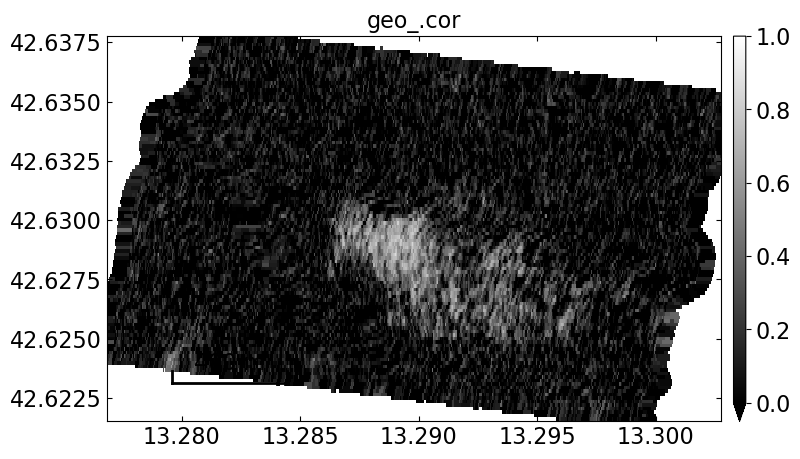

run view.py in MintPy version 1.6.1, date 2024-07-31
input file is gdal .tif file: /data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/predict/final.tif in float32 format
file size in y/x: (68, 417)
num of datasets in file final.tif: 1
datasets to exclude (0):
[]
datasets to display (1):
['band1']
data   coverage in y/x: (0, 0, 417, 68)
subset coverage in y/x: (0, 0, 417, 68)
data   coverage in lat/lon: (13.27996030765031, 42.635100548420475, 13.299977961630457, 42.625062505039594)
subset coverage in lat/lon: (13.27996030765031, 42.635100548420475, 13.299977961630457, 42.625062505039594)
------------------------------------------------------------------------
colormap: jet
figure title: final.tif
figure size : [10.0, 4.0]
reading data ...
data    range: [-0.6010803, 0.8595133] 1
display range: [-0.6010803, 0.8595133] 1
display data in transparency: 1.0
plot in geo-coordinate
plotting data as image via matplotlib.pyplot.imshow ...
plot scale bar: [0.2, 0.2, 0.1]
2025-12-02 18:1

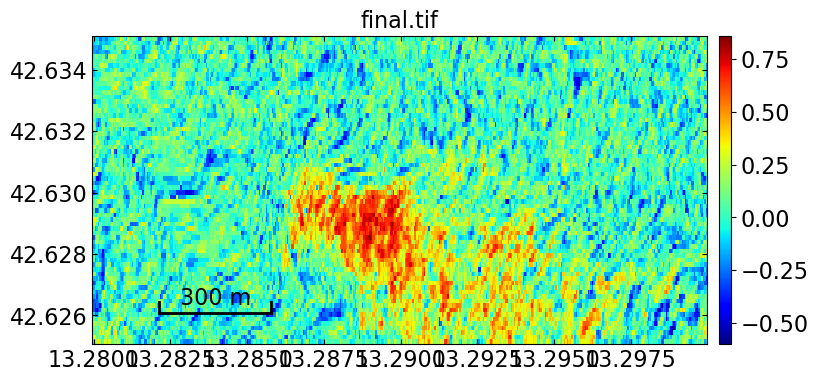

In [9]:
from mintpy.cli import view
view.main('/data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/predict/geo_.cor'.split())
view.main('/data6/WORKDIR/AmatriceSenDT22/merged/interferograms/cropped/predict/final.tif'.split())